# Wasserstein GAN (WGAN)

# Import Packages

In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import time
import glob
import imageio
from IPython import display
import pathlib
import zipfile
import torch
import sys
import pandas as pd

import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.datasets import FashionMNIST
import torchvision.transforms.functional as F


from skimage import io, transform

from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

# Device Mode

In [29]:
# Decide which device we want to run on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Generator

In [30]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()

        self.z_dim = z_dim

        self.gen = nn.Sequential(

            self.get_generator_block(z_dim,
                                     hidden_dim * 4,
                                     kernel_size=3,
                                     stride=2),

            self.get_generator_block(hidden_dim * 4,
                                     hidden_dim * 2,
                                     kernel_size=4,
                                     stride = 1),

            self.get_generator_block(hidden_dim * 2,
                                     hidden_dim ,
                                     kernel_size=3,
                                     stride = 2,
                                    ),

            self.get_generator_final_block(hidden_dim,
                                           im_chan,
                                           kernel_size=4,
                                           stride=2)


        )


    def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True),
        )


    def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Tanh()
            )


    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)



summary(Generator(100).to(device), (100,))
print(Generator(100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         230,656
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 830,785
Trainable params: 830,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

# Critic / Discriminator

In [31]:
class Critic(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            self.get_critic_block(im_chan,
                                         hidden_dim * 4,
                                         kernel_size=4,
                                         stride=2),

            self.get_critic_block(hidden_dim * 4,
                                         hidden_dim * 8,
                                         kernel_size=4,
                                         stride=2,),

            self.get_critic_final_block(hidden_dim * 8,
                                               1,
                                               kernel_size=4,
                                               stride=2,),

        )


    def get_critic_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
        )


    def get_critic_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
            )

    def forward(self, image):
        return self.disc(image)

summary(Critic().to(device) , (1,28,28))
print(Critic())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 13, 13]           1,088
       BatchNorm2d-2           [-1, 64, 13, 13]             128
         LeakyReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4            [-1, 128, 5, 5]         131,200
       BatchNorm2d-5            [-1, 128, 5, 5]             256
         LeakyReLU-6            [-1, 128, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]           2,049
Total params: 134,721
Trainable params: 134,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.51
Estimated Total Size (MB): 0.84
----------------------------------------------------------------
Critic(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2,

# Noise Creator Function

In [32]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

# MNIST Dataset Load

In [33]:
z_dim = 100
batch_size = 128

fixed_noise = get_noise(batch_size, z_dim, device=device)

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(
    FashionMNIST('.', download=True, transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

# Loaded Data Visualization

Time is 0.014961719512939453 sec
Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


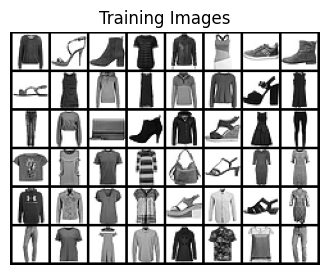

In [34]:
start = time.time()
dataiter = iter(dataloader)
images,labels = next(dataiter)
print ('Time is {} sec'.format(time.time()-start))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
inverted_images = F.invert(images[0:48])
plt.imshow(np.transpose(make_grid(inverted_images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

# Optimizer

In [35]:
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

crit  = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [36]:
# test = get_noise(batch_size, z_dim, device=device)
# test_gan = gen(test)
# grid_img = np.transpose(make_grid(test_gan[0].to(device), padding=2, normalize=True).cpu().detach(),(1,2,0))

# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(grid_img)

# Gradient Penalty

In [37]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)

    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

# Loss

In [38]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [39]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

# Model Training Process

In [40]:
def get_gradient(crit, real, fake, epsilon):

    mixed_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = crit(mixed_images)

    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,

    )[0]
    return gradient

In [41]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), show_fig=False, epoch=0):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    inverted_images = F.invert(image_unflat[0:num_images])
    image_grid = make_grid(inverted_images, nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show_fig:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

    plt.show()

In [43]:
n_epochs = 15
cur_step = 0
total_steps = 0
start_time = time.time()
cur_step = 0

generator_losses = []
critic_losses = []

C_mean_losses = []
G_mean_losses = []

c_lambda = 10
crit_repeats = 5
display_step = 50

for epoch in range(n_epochs):
    cur_step = 0
    start = time.time()
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        cur_step += 1
        total_steps += 1

        print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(dataloader)}\t"
        print_val += f"Epoch_Run_Time: {(time.time()-start):.6f}\t"
        print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
        print_val += f"Loss_G : {gen_loss:.6f}\t"
        print(print_val, end='\r',flush = True)

        ### Visualization code ###
#         if cur_step % display_step == 0 and cur_step > 0:
#             print()
#             gen_mean = sum(generator_losses[-display_step:]) / display_step
#             crit_mean = sum(critic_losses[-display_step:]) / display_step
#             print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
#             show_tensor_images(fake)
#             show_tensor_images(real)
#             step_bins = 20
#             num_examples = (len(generator_losses) // step_bins) * step_bins
#             plt.plot(
#                 range(num_examples // step_bins),
#                 torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
#                 label="Generator Loss"
#             )
#             plt.plot(
#                 range(num_examples // step_bins),
#                 torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
#                 label="Critic Loss"
#             )
#             plt.legend()
#             plt.show()

    print()
    gen_mean = sum(generator_losses[-cur_step:]) / cur_step
    crit_mean = sum(critic_losses[-cur_step:]) / cur_step

    C_mean_losses.append(crit_mean)
    G_mean_losses.append(gen_mean)

    print_val = f"Epoch: {epoch}/{n_epochs} Total Steps:{total_steps}\t"
    print_val += f"Total_Time : {(time.time() - start_time):.6f}\t"
    print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
    print_val += f"Loss_G : {gen_loss:.6f}\t"
    print_val += f"Loss_C_Mean : {crit_mean:.6f}\t"
    print_val += f"Loss_G_Mean : {gen_mean:.6f}\t"
    print(print_val)

    fake_noise = fixed_noise
    fake = gen(fake_noise)

    show_tensor_images(fake, show_fig=True,epoch=epoch)

    cur_step = 0
# Guardar el modelo entrenado
torch.save(gen.state_dict(), "generator.pth")



Output hidden; open in https://colab.research.google.com to view.

# After Tranning Loss Visualization

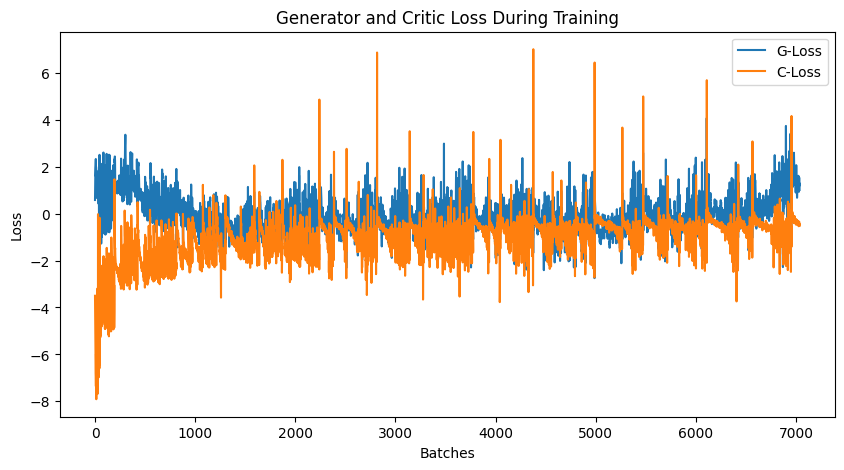

In [44]:
plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(generator_losses,label="G-Loss")
plt.plot(critic_losses,label="C-Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
plt.show()

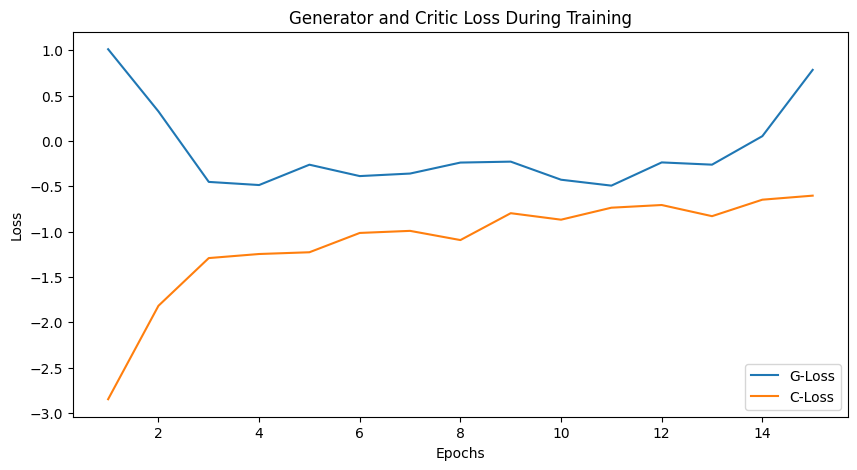

In [45]:
plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(range(1,n_epochs+1),G_mean_losses,label="G-Loss")
plt.plot(range(1,n_epochs+1),C_mean_losses,label="C-Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Testing WGAN

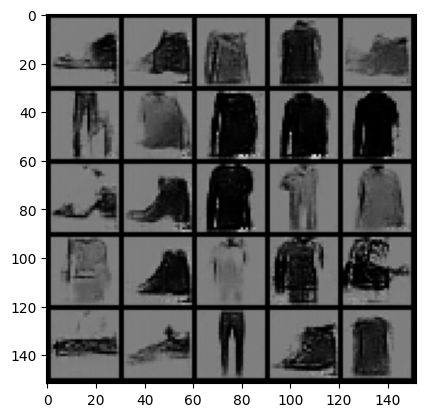

In [46]:
def show_new_gen_images(tensor_img, num_img=25):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    inverted_images = F.invert(unflat_img[0:num_img])
    img_grid = make_grid(inverted_images, nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze(),cmap='gray')
    plt.show()

num_image = 25
noise = get_noise(num_image, z_dim, device=device)
with torch.no_grad():
    fake_img = gen(noise)

show_new_gen_images(fake_img.reshape(num_image,1,28,28))

In [47]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


In [48]:
# Transformaciones básicas
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset de test (se usará para entrenamiento del clasificador)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [72]:
classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

for epoch in range(13):
    classifier.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}, Accuracy: {acc:.2f}%")


Epoch 1, Loss: 99.22, Accuracy: 77.46%
Epoch 2, Loss: 62.71, Accuracy: 86.03%
Epoch 3, Loss: 49.16, Accuracy: 88.72%
Epoch 4, Loss: 40.58, Accuracy: 90.78%
Epoch 5, Loss: 33.01, Accuracy: 92.31%
Epoch 6, Loss: 26.89, Accuracy: 93.97%
Epoch 7, Loss: 20.41, Accuracy: 95.06%
Epoch 8, Loss: 16.66, Accuracy: 96.03%
Epoch 9, Loss: 12.76, Accuracy: 96.98%
Epoch 10, Loss: 9.83, Accuracy: 97.91%
Epoch 11, Loss: 7.72, Accuracy: 98.32%
Epoch 12, Loss: 4.40, Accuracy: 99.22%
Epoch 13, Loss: 2.76, Accuracy: 99.51%


In [73]:
G = Generator(z_dim=100).to(device)
G.load_state_dict(torch.load("generator.pth"))
G.eval()
z_dim = 100
n_samples = 1000

with torch.no_grad():
    z = torch.randn(n_samples, z_dim).to(device)
    fake_images = G(z)
    fake_images = fake_images.view(-1, 1, 28, 28)


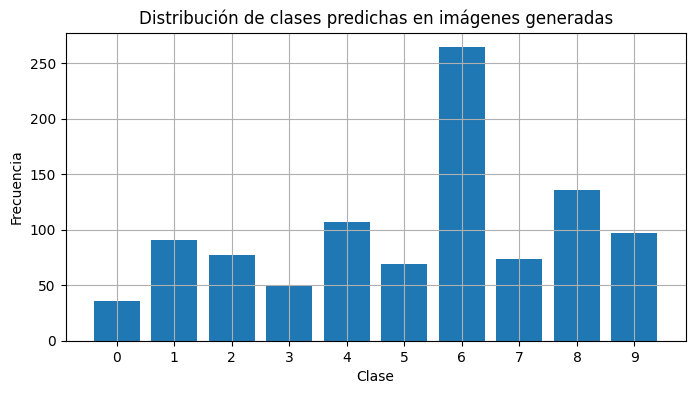

In [74]:
classifier.eval()
with torch.no_grad():
    preds = classifier(fake_images).argmax(dim=1).cpu().numpy()

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,4))
plt.hist(preds, bins=np.arange(11)-0.5, rwidth=0.8)
plt.xticks(range(10))
plt.title("Distribución de clases predichas en imágenes generadas")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


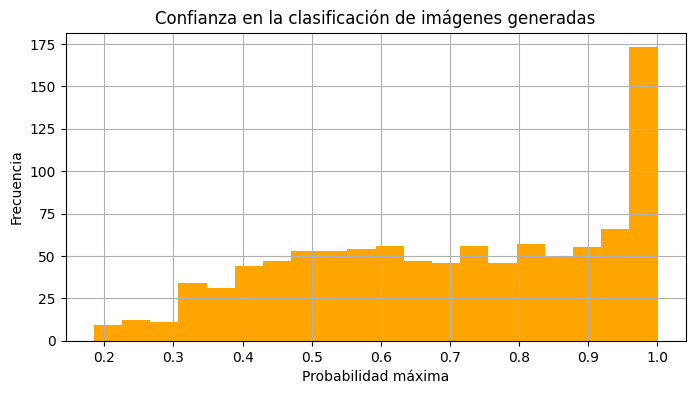

In [75]:
with torch.no_grad():
    probs = torch.softmax(classifier(fake_images), dim=1)
    confidences = probs.max(dim=1).values.cpu().numpy()

plt.figure(figsize=(8,4))
plt.hist(confidences, bins=20, color='orange')
plt.title("Confianza en la clasificación de imágenes generadas")
plt.xlabel("Probabilidad máxima")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()
